# 0. Import libraries and establish connection to GIS server

In [1]:
import numpy as np
import pandas as pd
from io import BytesIO
import requests
import pandas as pd
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
from arcgis.gis import GIS
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# TODO: ACTION REQUIRED: Change this to your own client ID
CLIENT_ID = "NmKYII9ABhRscPtr"

In [3]:
# Establish connection to GIS server using OAuth2.0
gis = GIS("https://utoronto.maps.arcgis.com", client_id=CLIENT_ID, verify_cert=False)
print("Successfully logged in as: " + gis.properties.user.username)

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://utoronto.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=NmKYII9ABhRscPtr&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=PL8LqsBosvesKgox88QSVbTEUJC4ZF&allow_verification=false
Successfully logged in as: yelin5_utoronto


# 1. Get Sports and Recreation Facilities Feature layer and Clean data

In [4]:
# Retrieve feature layer of the Open Database of Sports and Recreation Facilities - Canada
# url: https://utoronto.maps.arcgis.com/home/item.html?id=4814caea658941bb8596a342cd171269
src_url = "https://services.arcgis.com/wjcPoefzjpzCgffS/ArcGIS/rest/services/Sports_Recreation_Facilities_gdb/FeatureServer/0"
fl = FeatureLayer(url=src_url)

In [5]:
# Have a glance at the data
map_ca = gis.map('Canada')
map_ca.add_layer(fl)
map_ca

MapView(layout=Layout(height='400px', width='100%'))

In [6]:
# Turn feature layer into dataframe (SRF abbr. for Sports & Recreation Facilities)
# This step takes ~1 min on my Macbook Pro 2018
df_SRF = fl.query(as_df=True)
df_SRF.head(3)

,CSD_Name,CSD_UID,City,Facility_Name,Index_,Latitude,Longitude,OBJECTID,ODRSF_facility_type,PR_UID,...,Prov_Terr,Provider,SHAPE,Source_Facility_Type,Source_Format_Address,Street_Direction,Street_Name,Street_No,Street_Type,Unit
0,Brantford,3529006,brantford,11Bhe,1,43.167585,-80.242945,1,playground,35,...,on,brantford,"{""x"": -8932603.829472812, ""y"": 5337514.8521930...",..,..,..,..,..,..,..
1,Kitchener,3530013,kitchener,221 Queen,2,43.447172,-80.491427,2,pool,35,...,on,waterloo region,"{""x"": -8960264.680222288, ""y"": 5380285.6197073...",swimming pool – class b,221 queen st s,s,queen,221,st,..
2,Rivière-Bleue,2413025,rivière bleue,3 Bondaries Trails,3,47.435830,-69.042971,3,trail,24,...,qc,province of québec,"{""x"": -7685828.374574751, ""y"": 6013505.0459810...",..,"32, des pins e.",e,des-pins,32,..,..


In [7]:
# Check general info for the dataset
df_SRF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182001 entries, 0 to 182000
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CSD_Name               182001 non-null  object  
 1   CSD_UID                182001 non-null  int32   
 2   City                   182001 non-null  object  
 3   Facility_Name          182001 non-null  object  
 4   Index_                 182001 non-null  int32   
 5   Latitude               181899 non-null  float64 
 6   Longitude              181899 non-null  float64 
 7   OBJECTID               182001 non-null  int64   
 8   ODRSF_facility_type    182001 non-null  object  
 9   PR_UID                 182001 non-null  int32   
 10  Postal_Code            182001 non-null  object  
 11  Prov_Terr              182001 non-null  object  
 12  Provider               182001 non-null  object  
 13  SHAPE                  181899 non-null  geometry
 14  Source_Facility_Type

In [8]:
# Several columns have Null value, drop those rows
df_SRF.dropna(axis=0, how="any", inplace=True)

In [9]:
# We only need province and ODRSF_facility_type for the analysis, as we wanna compare the amount of different facilities in different provinces
df_SRF = df_SRF[["ODRSF_facility_type", "Prov_Terr"]]
df_SRF.head(3)

,ODRSF_facility_type,Prov_Terr
0,playground,on
1,pool,on
2,trail,qc


In [10]:
# Check how many facility type and provinces are there
df_SRF.nunique()

ODRSF_facility_type    18
Prov_Terr              10
dtype: int64

In [11]:
df_SRF["ODRSF_facility_type"].unique()

array(['playground', 'pool', 'trail', 'park', 'community centre', 'gym',
       'athletic park', 'arena', 'rink', 'skate park', 'splash pad',
       'stadium', 'beach', 'marina', 'casino', 'race track',
       'miscellaneous', 'sports field'], dtype=object)

In [12]:
df_SRF["Prov_Terr"].unique()

array(['on', 'qc', 'ab', 'mb', 'bc', 'nb', '..', 'ns', 'sk', 'nt'],
      dtype=object)

In [13]:
# ".." does not make sense in province, drop it
df_SRF = df_SRF[df_SRF["Prov_Terr"] != ".."]

In [14]:
# I am particularly interested in going to trail, park and gym, let's check those places!

def get_province_facility_quantity(df: pd.DataFrame, facility_type: str) -> pd.DataFrame:
    """
    Count the number of specified facilities in each province

    Attributes:
    df: pd.DataFrame
        Original Dataframe
    facility_type: str
        specified facility type

    Returns
    pd.DataFrame
        A dataframe contains the number of facility specified in each province
    """

    df_facility = df[df["ODRSF_facility_type"] == facility_type]
    return df_facility.groupby(by="Prov_Terr", as_index=False).count().rename(columns={"ODRSF_facility_type": facility_type})

df_trail = get_province_facility_quantity(df_SRF, "trail")
df_park = get_province_facility_quantity(df_SRF, "park")
df_gym = get_province_facility_quantity(df_SRF, "gym")


In [15]:
# Now lets merge the three dataframes into one!
from functools import reduce

data_frames = [df_trail, df_park, df_gym]
df_merged_facility = reduce(lambda left, right: pd.merge(left, right, on=['Prov_Terr'], how="outer"), data_frames)
df_merged_facility.fillna(0, inplace=True)
df_merged_facility

,Prov_Terr,trail,park,gym
0,ab,15332.0,4402,29.0
1,bc,18305.0,3052,27.0
2,mb,3.0,1255,2.0
3,nb,3994.0,262,44.0
4,ns,2741.0,915,0.0
5,on,95030.0,8915,85.0
6,qc,135.0,1162,11.0
7,sk,5345.0,561,0.0
8,nt,0.0,28,0.0


<AxesSubplot:xlabel='Prov_Terr'>

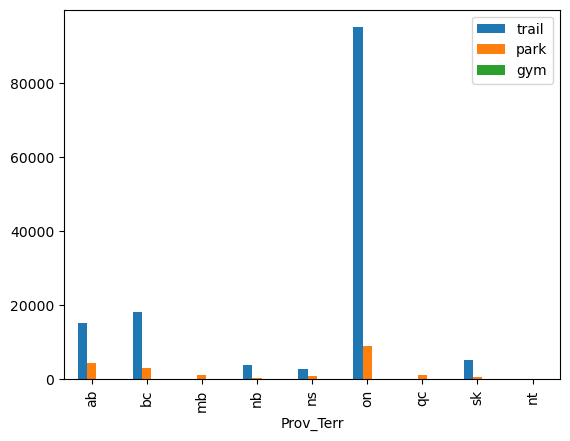

In [16]:
# Make a quick visualization here
df_merged_facility.set_index("Prov_Terr").plot.bar()

# 2. Load Canada Province Boundry map and merge it with the facility dataframe

In [17]:
# Try another api to load the map
ca_provinces_item = gis.content.get('d3fef65386df4e63b02d6e23bb98a1ee')
ca_provinces_item
flayer_ca_provinces = ca_provinces_item.layers[0]
df_ca_provinces = flayer_ca_provinces.query(as_df=True)
df_ca_provinces

,FID,postal,Nom_Fr,Name_EN,Shape_Leng,Shape_Area,Shape__Area,Shape__Length,SHAPE
0,1,MB,Manitoba,Manitoba,7.174885e+06,1.987391e+12,1.987391e+12,7.174885e+06,"{""rings"": [[[-9901534.7054, 7730176.5012], [-9..."
1,2,SK,Saskatchewan,Saskatchewan,6.105909e+06,1.936261e+12,1.936261e+12,6.105909e+06,"{""rings"": [[[-11283826.6741, 6273617.666], [-1..."
2,3,AB,Alberta,Alberta,6.480084e+06,2.046155e+12,2.046155e+12,6.480084e+06,"{""rings"": [[[-12245068.411, 6273608.8989], [-1..."
3,4,BC,Colombie-Britannique,British Columbia,2.995914e+07,2.864108e+12,2.864108e+12,2.995914e+07,"{""rings"": [[[-13718912.1255, 6177039.9907], [-..."
4,5,NU,Nunavut,Nunavut,2.710973e+08,2.270183e+13,2.270183e+13,2.710973e+08,"{""rings"": [[[-8802092.9206, 6735898.7062], [-8..."
5,6,NT,Territoires du Nord-Ouest,Northwest Terrritories,5.378878e+07,8.759245e+12,8.759245e+12,5.378878e+07,"{""rings"": [[[-15146891.1403, 10790828.9769], [..."
6,7,YT,Yukon,Yukon,9.703122e+06,2.472298e+12,2.472298e+12,9.703122e+06,"{""rings"": [[[-15683844.2735, 10948443.6885], [..."
7,8,ON,Ontario,Ontario,9.645718e+06,2.634173e+12,2.634173e+12,9.645718e+06,"{""rings"": [[[-8852214.9108, 6615242.5327], [-8..."
8,9,QC,Québec,Québec,2.857808e+07,4.296852e+12,4.296852e+12,2.857808e+07,"{""rings"": [[[-8230747.0837, 5670496.6584], [-8..."
9,10,NB,Nouveau-Brunswick,New Brunswick,3.044798e+06,1.541619e+11,1.541619e+11,3.044798e+06,"{""rings"": [[[-7432741.5151, 5589409.0255], [-7..."


In [18]:
# We only keep postal, Name_En and SHAPE
df_ca_provinces = df_ca_provinces[["postal", "Name_EN", "SHAPE"]]
df_ca_provinces

,postal,Name_EN,SHAPE
0,MB,Manitoba,"{""rings"": [[[-9901534.7054, 7730176.5012], [-9..."
1,SK,Saskatchewan,"{""rings"": [[[-11283826.6741, 6273617.666], [-1..."
2,AB,Alberta,"{""rings"": [[[-12245068.411, 6273608.8989], [-1..."
3,BC,British Columbia,"{""rings"": [[[-13718912.1255, 6177039.9907], [-..."
4,NU,Nunavut,"{""rings"": [[[-8802092.9206, 6735898.7062], [-8..."
5,NT,Northwest Terrritories,"{""rings"": [[[-15146891.1403, 10790828.9769], [..."
6,YT,Yukon,"{""rings"": [[[-15683844.2735, 10948443.6885], [..."
7,ON,Ontario,"{""rings"": [[[-8852214.9108, 6615242.5327], [-8..."
8,QC,Québec,"{""rings"": [[[-8230747.0837, 5670496.6584], [-8..."
9,NB,New Brunswick,"{""rings"": [[[-7432741.5151, 5589409.0255], [-7..."


In [19]:
# We can now join the two Tables! Just after applying uppercase to the Prov_Terr
df_merged_facility['Prov_Terr'] = df_merged_facility['Prov_Terr'].str.upper()

df_final = pd.merge(left=df_ca_provinces, right=df_merged_facility, how="inner", left_on="postal", right_on="Prov_Terr")
df_final

,postal,Name_EN,SHAPE,Prov_Terr,trail,park,gym
0,MB,Manitoba,"{'rings': [[[-9901534.7054, 7730176.5012], [-9...",MB,3.0,1255,2.0
1,SK,Saskatchewan,"{'rings': [[[-11283826.6741, 6273617.666], [-1...",SK,5345.0,561,0.0
2,AB,Alberta,"{'rings': [[[-12245068.411, 6273608.8989], [-1...",AB,15332.0,4402,29.0
3,BC,British Columbia,"{'rings': [[[-13718912.1255, 6177039.9907], [-...",BC,18305.0,3052,27.0
4,NT,Northwest Terrritories,"{'rings': [[[-15146891.1403, 10790828.9769], [...",NT,0.0,28,0.0
5,ON,Ontario,"{'rings': [[[-8852214.9108, 6615242.5327], [-8...",ON,95030.0,8915,85.0
6,QC,Québec,"{'rings': [[[-8230747.0837, 5670496.6584], [-8...",QC,135.0,1162,11.0
7,NB,New Brunswick,"{'rings': [[[-7432741.5151, 5589409.0255], [-7...",NB,3994.0,262,44.0
8,NS,Nova Scotia,"{'rings': [[[-7303736.9229, 5377372.1386], [-7...",NS,2741.0,915,0.0


# 3. Now, it's time for VISUALIZATION!!!

In [20]:
# 3.1 Visualize the number of parks in each CA province
map_park = gis.map('Canada')
map_park.clear_graphics()
df_final.spatial.plot(  kind='map', map_widget=map_park,
                                  renderer_type='c',  # for class breaks renderer
                                  method='esriClassifyNaturalBreaks',  # classification algorithm
                                  class_count=3,  # choose the number of classes
                                  col='park',  # numeric column to classify
                                  cmap='inferno',  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
map_park


MapView(layout=Layout(height='400px', width='100%'))

In [21]:
# 3.2 Visualize the number of trails in each CA province
map_trail = gis.map('Canada')
map_trail.clear_graphics()
df_final.spatial.plot(  kind='map', map_widget=map_trail,
                                  renderer_type='c',  # for class breaks renderer
                                  method='esriClassifyNaturalBreaks',  # classification algorithm
                                  class_count=3,  # choose the number of classes
                                  col='trail',  # numeric column to classify
                                  cmap='inferno',  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
map_trail

MapView(layout=Layout(height='400px', width='100%'))